# ACOのアニメーションを用いた視覚化
## 取り組んだ内容
探索問題について取り組んだ。具体的には、重み付きグラフのうち、異なる二つのノードをスタートとゴールと決め、スタートからゴールまでの最短経路を、Ant Colony Optimization（以下、ACOと呼ぶ。） を用いて探索するコードを実装した。また、探索の進む様子を表すアニメーションを探索する際に、合わせて出力するようにした。ACOは本来、巡回セールスマン問題などNP困難な経路探索問題などに用いられる手法であり、必ず最適経路を見つけられるわけではないので、ここで扱うような簡単な問題に対して適切な手法とは言えない。しかし、今回の目的は、ACOの手法を理解しやすいように、アニメーションを作成することなので、今回の簡単な問題設定は初学者がACOを理解する上では適切であろう。

## ACO
ここでは、ACOについて簡単な説明を与える。

### 概要

ACO（Ant Colony Optimization：アントコロニー最適化）とは、自然界におけるアリの行動原理を模倣して構築された、組合せ最適化問題を解くためのメタヒューリスティックアルゴリズムである。特に、巡回セールスマン問題（TSP）やグラフ探索といった問題に対して効果的な手法として広く研究されている。

### 背景

アリは食料源と巣の間にフェロモンを残し、その情報を用いて他のアリが効率的な経路を見つけることが知られている。ACOは、このフェロモンによる経路選択メカニズムをアルゴリズムに応用したものである。

### アルゴリズムの基本的な流れ

1. 問題空間をグラフで表現し、各エッジに初期フェロモン量を設定する。
2. 複数の人工アリがランダムに経路を探索する(フェロモンの多い経路を選びやすい)。
3. 各アリの経路の良さに応じてフェロモンを更新する（例：距離の逆数を追加する）。
4. フェロモンは時間とともに蒸発するように減少させる（探索の多様性を保つため）。
5. 上記の過程を繰り返し、最適解または準最適解を導出する。

### 数式によるモデル化

アリ \( $k$ \) がノード \( $i$ \) にいるとき、次にノード \( $j$ \) を選択する確率 \( $p_{ij}^{k}$ \) は以下で与えられる：

$$
p_{ij}^{k} = \frac{\tau_{ij}^{\alpha} \cdot \eta_{ij}^{\beta}}{\sum_{l \in \text{未訪問}} \tau_{il}^{\alpha} \cdot \eta_{il}^{\beta}}
$$

- \( $\tau_{ij}$ \)：エッジ \( $(i, j)$ \) におけるフェロモンの量  
- \( $\eta_{ij}$ \)：エッジ \( $(i, j)$ \) のヒューリスティック情報（例：距離の逆数）  
- \( $\alpha, \beta$ \)：フェロモンとヒューリスティックの重要度を調整するパラメータ

## 実装内容
以下のコードセルでは、ランダムに重み付き無向グラフを作成し、その様子を作図している。node_numとedge_rateの値を調整することで、様々なグラフを作成できる。（node_numはノードの数を、edge_rateはエッジが作成される確率を決める。）

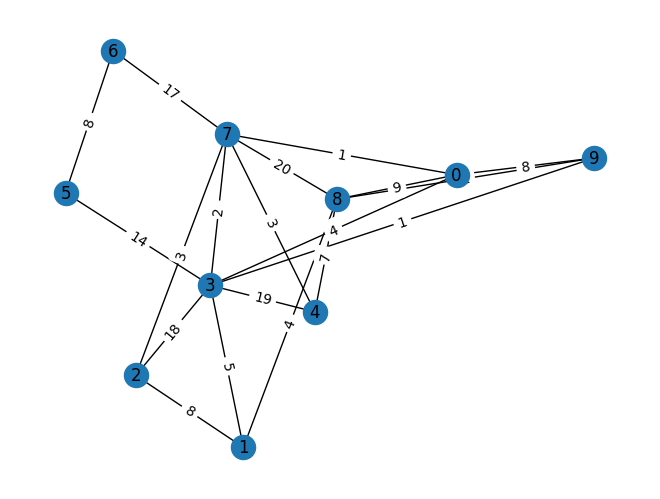

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(42)

node_num = 10
edge_rate = 0.3

G = nx.fast_gnp_random_graph(node_num, edge_rate, seed=42)

for u, v in G.edges():
    G[u][v]['weight'] = random.randint(1, 20) 

pos = nx.spring_layout(G, seed=6)
nx.draw(G, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

次に、上のコードセルで出力された図を見て、スタートとゴールのノードを決める。（startとgoalは異なる必要がある。）

In [3]:
start = 6
goal = 2

ダイクストラ法を用いて、ACOで求めたい最適経路とそのコスト（経路の道のり）を求める。

In [ ]:
path_dijkstra = nx.dijkstra_path(G, start, goal, weight='weight')
cost_dijkstra = nx.dijkstra_path_length(G, start, goal, weight='weight')

print("最短経路:", path_dijkstra)
print("コスト:", cost_dijkstra)

最短経路: [6, 7, 2]
コスト: 20


実際に、ACOを実行する。ACOはAntColonyというクラスで行われるが、オプションの引数でアリの数やイテレーションの回数など、細かな設定を変更できる。特に、AntColony.runの引数として、mk_anim=Falseとすることで、アニメーションを作成せずに、最適経路の探索のみが行われる。アニメーションを作成する処理は実行時間がかなりかかるので、アリの数やイテレーションの数を増やした際には、この引数を指定しないと、実行時間が非常にかかってしまうので注意が必要。また、アニメーションはデフォルトではAOC.mp4というファイル名で出力される。

ACOによる最短経路: [6, 7, 2]
ACOによるコスト: 20


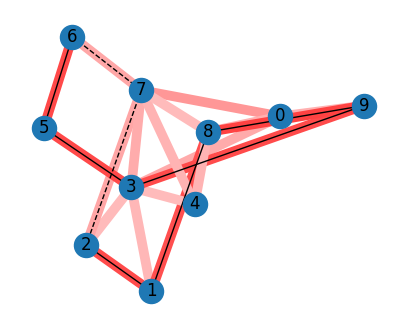

In [ ]:
import numpy as np
from matplotlib import animation
np.random.seed(42)

class AntColony:
    def __init__(self, graph, start, goal, n_ants=10, n_iterations=10, decay=0.9, alpha=1, beta=2):
        self.graph = graph
        self.start = start
        self.goal = goal
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.pheromone = np.ones((graph.number_of_nodes(), graph.number_of_nodes()))

    def run(self, anim_file_name="ACO.mp4", mk_anim=True):
        self.shortest_path = None
        self.shortest_cost = float('inf')
        if mk_anim:
            fig = plt.figure(figsize=(5,4))
            self.pos = nx.spring_layout(G, seed=6)
            anim = animation.FuncAnimation(fig, self.__imply_ACO_mk_anim, frames=self.n_iterations, init_func=self.__FuncAnimation_init, interval=500)
            anim.save(anim_file_name, writer="ffmpeg")   
        else:
            self.__imply_ACO()
        return self.shortest_path, self.shortest_cost
    
    def __FuncAnimation_init(self):#これがないとFuncAnimationが0フレーム目を二回呼び出す
        pass
    
    def __imply_ACO_mk_anim(self, _):
        all_paths = self.__gen_all_paths()
        self.__update_pheromone(all_paths)
        best_path = [] #こうしておかないと、ゴールにたどり着けたアリがいないときに、__mk_edgelistが不具合を起こす
        best_cost = float('inf')
        for path, cost in all_paths:
            if cost < best_cost:
                best_cost = cost
                best_path = path
        if best_cost < self.shortest_cost:
            self.shortest_path = best_path
            self.shortest_cost = best_cost
        plt.clf()
        plt.axis('off')
        nx.draw_networkx_edges(self.graph, self.pos, edge_color='#ffffff', width=7.0) #これがないと毎フレームグラフの位置がずれる
        for u, v in list(self.graph.edges()):
            pheromone_sum = self.pheromone[u][v] + self.pheromone[v][u]
            intensity = format(max(0, 256 - int(pheromone_sum * 100)), 'x')
            nx.draw_networkx_edges(self.graph, self.pos, edgelist=[(u,v)], edge_color='#ff'+intensity+intensity, width=7.0)
        nx.draw_networkx(self.graph, self.pos, edgelist=self.__mk_edgelist(best_path))
        nx.draw_networkx_edges(self.graph, self.pos, edgelist=self.__mk_edgelist(self.shortest_path), style='dashed')

    def __imply_ACO(self):
        for _ in range(self.n_iterations):
            all_paths = self.__gen_all_paths()
            self.__update_pheromone(all_paths)
            for path, cost in all_paths:
                if cost < self.shortest_cost:
                    self.shortest_path = path
                    self.shortest_cost = cost

    def __gen_all_paths(self):
        all_paths = []
        for _ in range(self.n_ants):
            path, cost = self.__gen_path(self.start)
            if cost != -1:
                all_paths.append((path, cost))
        return all_paths

    def __gen_path(self, start):
        path = [start]
        cost = 0
        visited = {start}
        while path[-1] != self.goal:
            move = self.__pick_move(path[-1], visited)
            if move is None:
                cost = -1
                break 
            path.append(move)
            cost += self.graph[path[-2]][path[-1]]['weight']
            visited.add(move)
        return path, cost

    def __pick_move(self, current, visited):
        neighbors = [i for i in self.graph.neighbors(current) if i not in visited]
        if not neighbors:
            return None
        probs = np.array([((self.pheromone[current][i] ** self.alpha) * (1.0 / self.graph[current][i]['weight'] ** self.beta)) for i in neighbors])
        probs /= probs.sum()
        return int(np.random.choice(neighbors, p=probs))

    def __update_pheromone(self, all_paths):
        self.pheromone *= self.decay
        for path, cost in all_paths:
            for i in range(len(path) - 1):
                self.pheromone[path[i]][path[i+1]] += 1.0 / cost

    def __mk_edgelist(self, path):
        edgelist = set()
        for i in range(len(path)-1):
            edgelist.add((path[i], path[i+1]))
        return edgelist


# 実行
aco = AntColony(G, start, goal)
path_aco, cost_aco = aco.run()
print("ACOによる最短経路:", path_aco)
print("ACOによるコスト:", cost_aco)

### 出力されたアニメーションの見方
まず、１フレームは１イテレーションに対応して、各フレームが１イテレーション終了したごとの状態を表現す。黒色の実線がそのイテレーションの中でアリが発見した最短経路を表す。黒色の点線は、そのイテレーションまでに見つけた経路の中で最適な経路である。すなわち、最終フレームの黒の点線の経路が返り値の経路である。
また、赤の太い線はフェロモンの量を表しており、赤色が濃いほどフェロモンが多い（アリがその経路選択しやすい）ことを表す。ただし、ACOの実際の処理としては、フェロモンはエッジ上の向きごとに定義されている。（各エッジに行きと帰りの二つの値がある。）しかし、このままでは上手く視覚化できないため、エッジごとに両方の向きのフェロモンの和をそのエッジのフェロモン量としてアニメーションにしている。

## AIの利用について
class AntColonyのプロトタイプをAIに作成してもらった。しかし、論理エラーが多数あったことと、アニメーションを作成する機能がついていなかったため、AIが作成したプロトタイプをもとに、半分以上自分で書きなおした。ACOの説明については、ChatGPTに作成してもらったものを、少し手直ししたものを利用した。また、VSCODEの入力補完と、検索ツールとしてChatGPTを利用した。

## 参考文献

- [アントコロニー最適化(ACO)を救いたい](https://qiita.com/ganyariya/items/25824f1502478a673005#6-%E3%82%BD%E3%83%BC%E3%82%B9%E3%82%B3%E3%83%BC%E3%83%89)
- [手書きでグラフ描いてない？Networkxならそれ、一瞬ですよ。](https://qiita.com/Pitta/items/01441f20a27880add3d2#%E7%82%B9%E3%81%AE%E4%BD%8D%E7%BD%AE%E3%82%92%E8%AA%BF%E6%95%B4)
- [NetworkXによるランダムグラフ生成＆プロットとダイキストラ法による最短経路アルゴリズムを試してみた話](https://qiita.com/o_range/items/18af9a0bb16f72313add)
- [【Python】NetworkXのネットワーク描画をmatplotlibでgifアニメ化](https://kiito.hatenablog.com/entry/2013/12/02/205352)
- [MatplotlibのFuncAnimationのコールバック関数が初期値で2回実行される](https://qiita.com/t0d4_/items/0f2b41782a6177d35e65)
